# 3. KODEX200 12개월평균 절대모멘텀

In [1]:
import pandas as pd
import numpy as np

### 함수

In [2]:
def 월별수익(data):
    result = data/data.shift(1)
    return result

def 절대모멘텀(data,month):
    # shift를 사용하여 원화는 달의 수익률을 구한다
    # 당월주가 > n 개월 전 주가(n개월 모멘텀 > 0) --> 주식매수
    # 당월주가 < n 개월 전 주가(n개월 모멘텀 < 0) --> 주식매도
    result = np.where(data/data.shift(month)>1,1,0)
    return result

def CAGR(data):
    y = data.index.year.unique()
    result = (data[-1]/data[0])**(1/len(y))-1
    return np.round(result,4)

def MDD(data):
    window = len(data)

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = data.rolling(window, min_periods=1).max()
    Roll_Max.rename("Roll_Max", inplace=True)
    Drawdown = data/Roll_Max - 1.0
    Drawdown.rename("Drawdown", inplace=True)

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Drawdown = Drawdown.rolling(window, min_periods=1).min()
    Max_Drawdown.rename("Max_Drawdown", inplace=True)
    
    return np.round(Drawdown,4), np.round(Max_Drawdown,4)

### 7개월 평균 절대모멘텀

In [3]:
def 개월7평균절대모멘텀(data):
    # shift를 사용하여 원화는 달의 수익률을 구한다
    # 당월주가 > n 개월 전 주가(n개월 모멘텀 > 0) --> 주식매수
    # 당월주가 < n 개월 전 주가(n개월 모멘텀 < 0) --> 주식매도
    result = 0
    for i in range(1,8):
        result += np.where(data/data.shift(i)>1,1,0) 
    return np.round(result/7,2)  #7개월 평균값 return

# Main

### csv 파일 읽어오기

In [4]:
df = pd.read_csv("KODEX200_monthly_data.csv", encoding="utf-8")

### Index는 datetime 형으로 변환하기

In [5]:
df.index = pd.to_datetime(df["Date"])
df.head()

,Date,Open,High,Low,Close,Volume,Change
Date,,,,,,,
2010-01-29,2010-01-29,19052,19066,18668,18742,2717811,-0.026996
2010-02-26,2010-02-26,18611,18683,18514,18559,974615,0.000431
2010-03-31,2010-03-31,19853,19858,19729,19789,883019,-0.003776
2010-04-30,2010-04-30,20331,20403,20313,20377,758179,0.007814
2010-05-31,2010-05-31,18887,19126,18882,19134,1979678,0.012220


### 7개월평균 절대모멘텀 값 구하기, CAGR/MDD 구하기

In [6]:
KODEX200 = df["Close"]
KODEX200.rename("KODEX200", inplace=True)
KODEX200 = KODEX200/KODEX200[0] * 1  #re-scale로 1로 맞춤
KODEX200_CAGR = CAGR(KODEX200) # CAGR 구하기
KODEX200_DD,KODEX200_MDD  = MDD(KODEX200)  # MDD 구하기
누적월별수익 = 월별수익(KODEX200).cumprod()  #누적수익률 구하기
print ("KODEX200 CAGR {:.2%} ".format(KODEX200_CAGR))
print ("KODEX200 MDD {:.2%}".format(KODEX200_MDD.min()))
print ("누적월별수익 {:.2%}".format(누적월별수익[-1]))
print ("")

결과 = KODEX200.copy()

KODEX200 CAGR 4.03% 
KODEX200 MDD -20.67%
누적월별수익 148.38%



#### 절대모멘텀  3월이 '0'이상 이라면 4월 월수익을 사용한다. ? 3월 월수익은 2월달 투입금액의 수익이다.

In [7]:
score = 개월7평균절대모멘텀(KODEX200)
월별수익 = 월별수익(KODEX200)
자본금 = [1]  #첫달 자본금 1로 설정
매수금액 = 0
매매금액= 0

for i in range(0,len(score)):
    # 첫달 매수금액
    매수금액 = score[i] * 자본금[i]
    try:
        #두번째달 수익과 첫달 매수금액 곱하기
        매매금액 = 매수금액 * 월별수익[i+1]
        #첫달 자본금 유지하고 두번째 달에 투자수익금 입력
        자본금.append((자본금[i] - 매수금액) + 매매금액)  #현금 = 자본금 - 매수금액
    except IndexError:  #마지막달 매수금액의 투자수익은 구할수없어 pass 처리함
        pass

In [8]:
자본 = pd.DataFrame(자본금, index=KODEX200.index)
자본.head()

,0
Date,
2010-01-29,1.000000
2010-02-26,1.000000
2010-03-31,1.000000
2010-04-30,1.008617
2010-05-31,0.982161


In [9]:
자본금CAGR = CAGR(자본[0])
자본금DD, 자본금MDD = MDD(자본[0])

print ("KODEX200 CAGR {:.2%} ".format(KODEX200_CAGR))
print ("KODEX200 MDD {:.2%}".format(KODEX200_MDD.min()))
print ("누적월별수익 {:.2%}".format(누적월별수익[-1]))
print ("")

print ("7개월평균절대모멘텀 CAGR {:.2%} ".format(자본금CAGR))
print ("7개월평균절대모멘텀 MDD {:.2%}".format(자본금MDD.min()))
print ("7개월평균절대모멘텀 누적월별수익 {:.2%}".format(자본[0][-1]))

KODEX200 CAGR 4.03% 
KODEX200 MDD -20.67%
누적월별수익 148.38%

7개월평균절대모멘텀 CAGR 1.60% 
7개월평균절대모멘텀 MDD -23.41%
7개월평균절대모멘텀 누적월별수익 117.16%


### 그래프 그리기

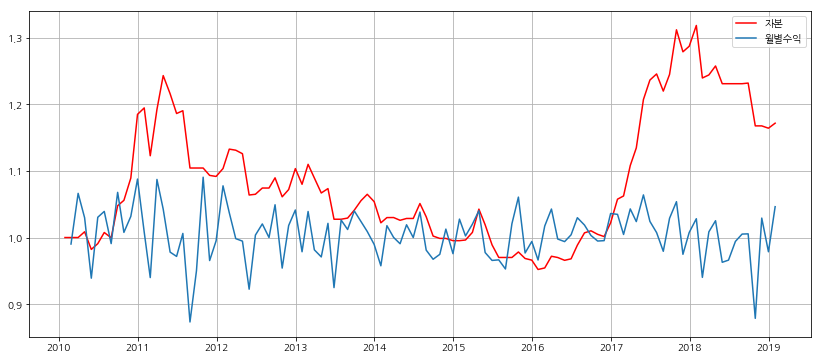

In [10]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")
%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(자본,color="Red", label="자본")
ax.plot(월별수익, label="월별수익")
ax.grid(True)
ax.legend();

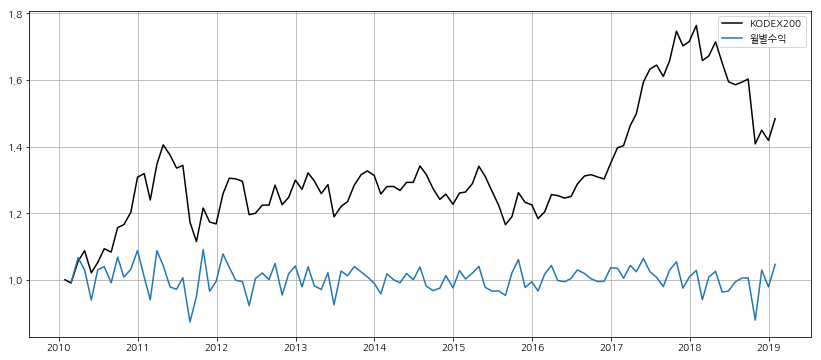

In [11]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
#score = pd.DataFrame(score,index=KODEX200.index)
ax.plot(KODEX200,color="Black",label="KODEX200")
ax.plot(월별수익, label="월별수익")
ax.grid(True)
ax.legend();

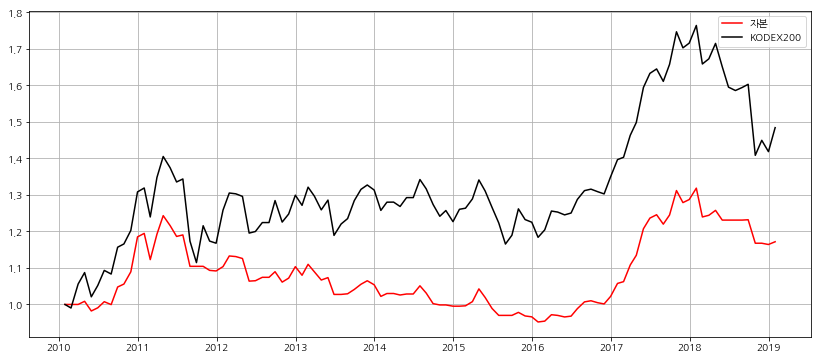

In [12]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(자본,color="Red", label="자본")
ax.plot(KODEX200,color="Black", label="KODEX200")
ax.grid(True)
ax.legend();

### score 그래프

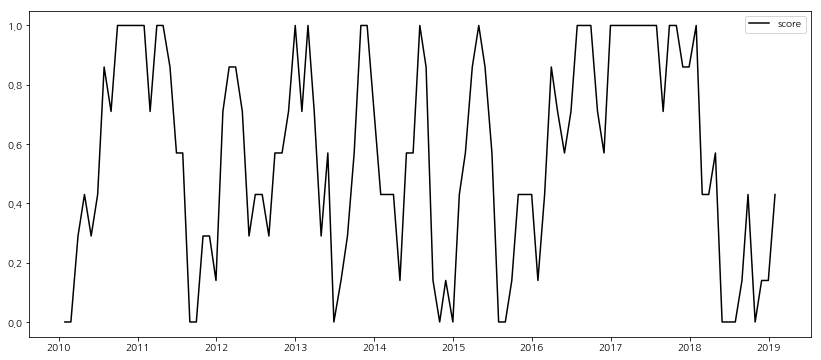

In [13]:
df_score = pd.DataFrame(score,index=KODEX200.index)

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(df_score,color="Black",label="score");
ax.legend();

### Monthly MDD & Max MDD

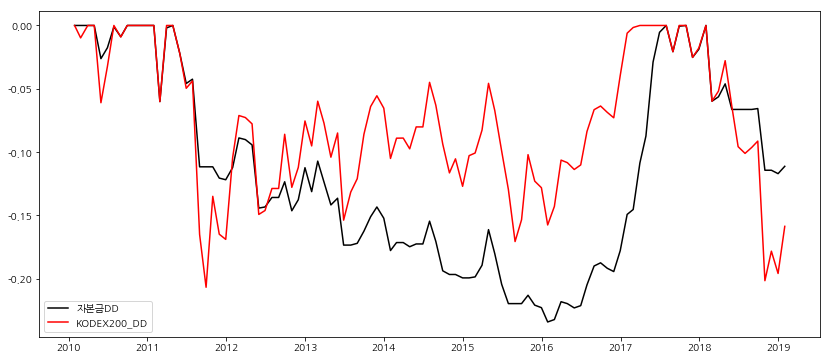

In [14]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(자본금DD,color="Black",label="자본금DD");
ax.plot(KODEX200_DD,color="Red", label="KODEX200_DD");
ax.legend();

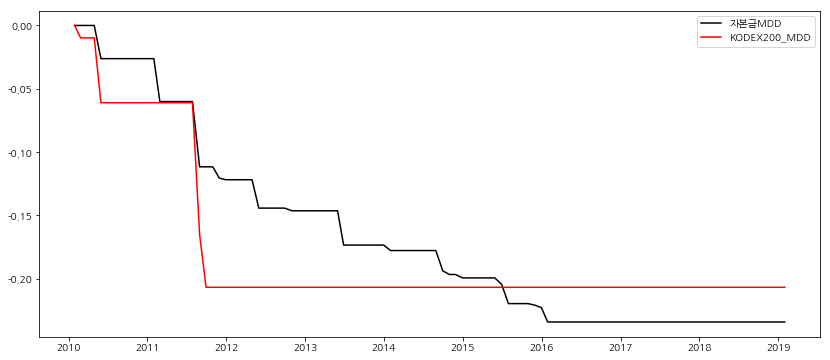

In [15]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(자본금MDD,color="Black",label="자본금MDD");
ax.plot(KODEX200_MDD,color="Red", label="KODEX200_MDD");
ax.legend();